### Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mayavi import mlab

from typing import Callable, Optional, Tuple

from scipy.stats import burr12, norm, multivariate_normal


********************************************************************************
         to build the TVTK classes (9.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



In [9]:
"""
These are standard univariate kernels where bandwidth h is not yet implemented.

By default ...

    Gauss   h = infty
    EPA     h = 1
    Window  h = 1

Using simple transformations, we can obtain kernels with specific bandwidths:

K_h = 1/h * K((x_i - x) / h)

"""

def kernel_gauss(x: np.array) -> np.array:
    return np.exp(-x ** 2 / 2) / np.sqrt(2 * np.pi)

def kernel_epa(x: np.array) -> np.array:
    return np.where(np.abs(x) <= 1, 3/4 * (1 - x**2), 0)

def kernel_window(x: np.array) -> np.array:
    return np.where(np.abs(x) <= 1, 1/2, 0)

def kernel_sinc(x: np.array) -> np.array:
    return np.sin(np.pi * x) / (np.pi * x)


"""
Now extending to multivariate kernels. The simplest multivariate extension is the product kernel:

K(x) = K_1(x_1) * ... * K_d(x_d)

where each K_i is a univariate kernel.

"""

def prod_kernel(x: np.array, kernel: Callable = kernel_epa) -> np.array:

    """
    Returns the product of `kernel` evaluated at each entry of `x`.
    """

    # Apply the kernel function element-wise for each dimension
    res = np.prod(kernel(x), axis=1)
    
    return res

def kde(x: np.array, sample: np.array, kernel: Callable, h: Optional[float]=None) -> float:
    
    """
    Kernel density estimator for `sample` using a `kernel` and optional `h` = bandwidth.
    Returns the estimated density f_kde at a given point / array of points  `x`.

    """

    d = sample.ndim
    n = len(sample)

    if h is None:
        # Silverman's rule of thumb
        h = np.std(sample) * n ** (-1 / 5)

    f_kde = np.zeros(len(x))

    if d > 1:
        for idx, eval_pt in enumerate(x):
            f_kde[idx] = (1/(n * h**d)) * prod_kernel((sample - eval_pt) / h, kernel).sum()
        
    else :
        for idx, eval_pt in enumerate(x):
            f_kde[idx] = (1/(n * h)) * kernel((sample - eval_pt) / h).sum()

    return f_kde

### Kernel Functions

### 1-dim Kernels

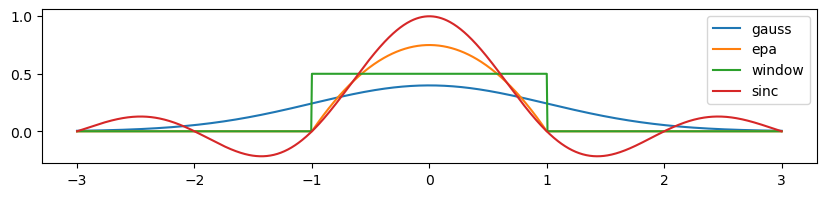

In [10]:
x = np.linspace(-3, 3, 1000)

plt.figure(figsize=(10, 2))
plt.plot(x, kernel_gauss(x), label='gauss')
plt.plot(x, kernel_epa(x), label='epa')
plt.plot(x, kernel_window(x), label='window')
plt.plot(x, kernel_sinc(x), label='sinc')
plt.legend(loc='upper right')
plt.show()

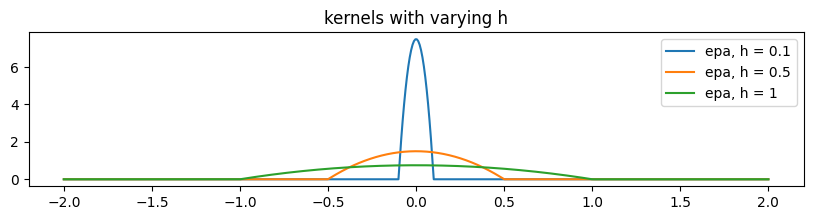

In [31]:
h_arr = [0.1, 0.5, 1]
x = np.linspace(-2, 2, 500)

plt.figure(figsize=(10, 2))

for h in h_arr:
    # plt.plot(x, kernel_gauss(x / h) / h, label=f'gauss, h = {h}')
    plt.plot(x, kernel_epa(x / h) / h, label=f'epa, h = {h}')

plt.legend(loc='upper right')
plt.title(f'kernels with varying h')
plt.show()

#### 1-dim KDE

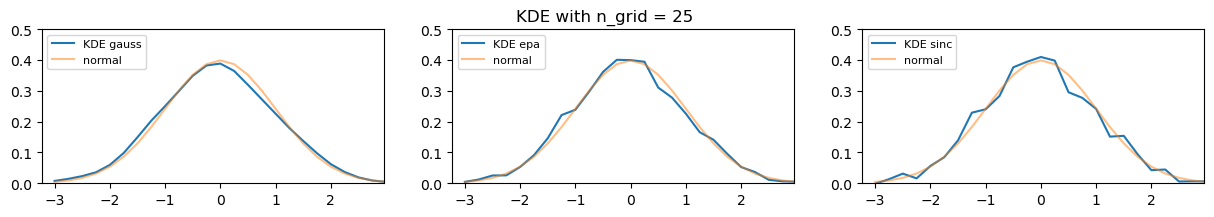

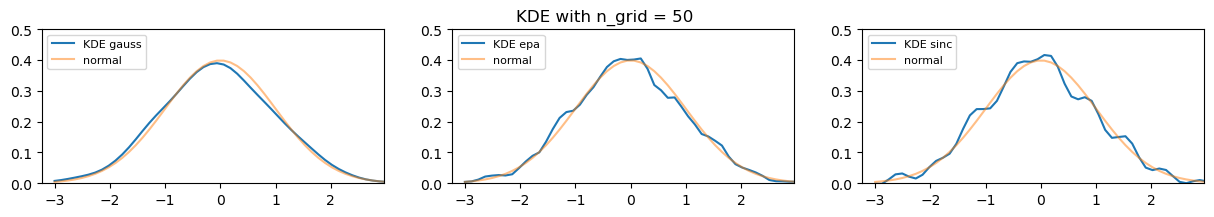

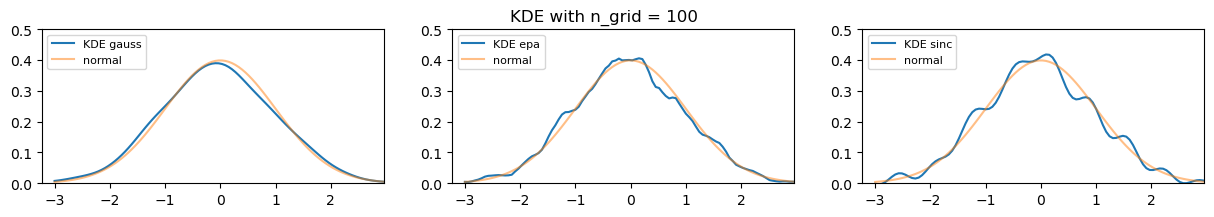

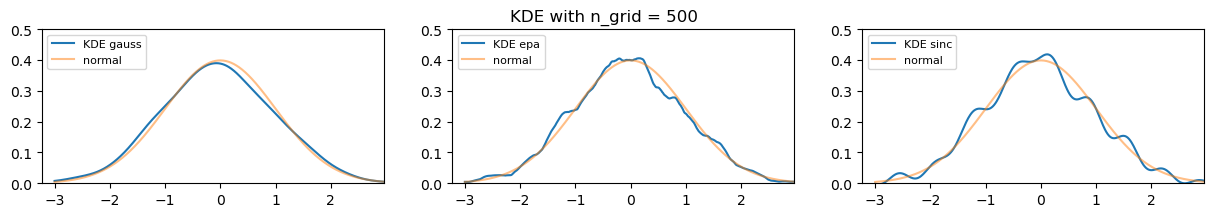

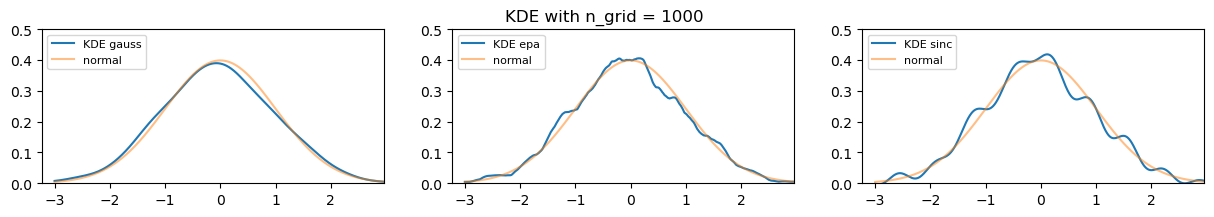

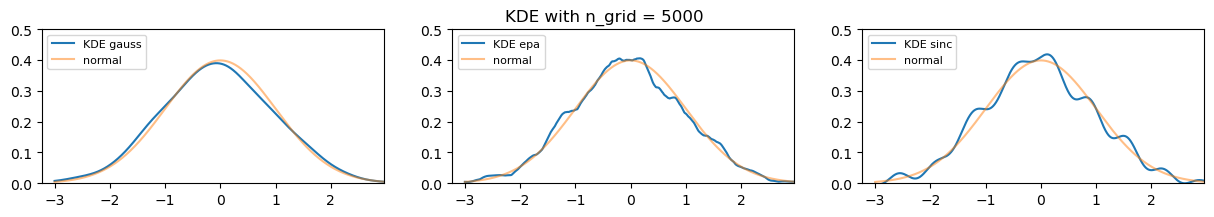

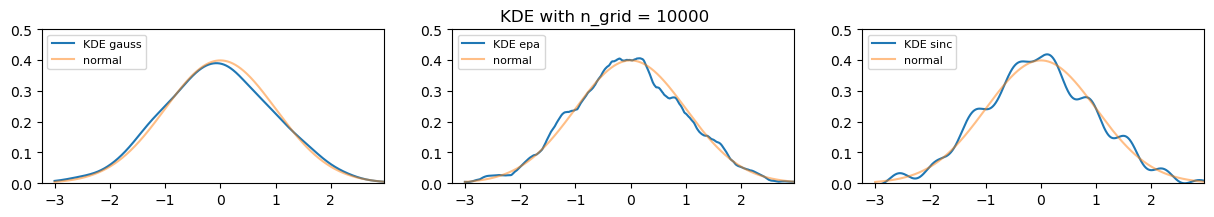

In [12]:
np.random.seed(123)
n = 500
# data = burr12(c=2, d=4).rvs(size=n)
data = norm.rvs(size=n)

x_lim = (min(data), max(data))
y_lim = (0, 0.5)

for n_grid in [25, 50, 100, 500, 1_000, 5_000, 10_000]:

    x = np.linspace(-3, 3, n_grid)

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,2))

    ax1.plot(x, kde(x, data, kernel_gauss), label="KDE gauss")
    ax2.plot(x, kde(x, data, kernel_epa), label="KDE epa")
    ax3.plot(x, kde(x, data, kernel_sinc), label="KDE sinc")

    for ax in (ax1, ax2, ax3) :
        # ax.plot(x, burr12(c=2, d=4).pdf(x), label="Burr XII", alpha=.5)
        ax.plot(x, norm.pdf(x), label="normal", alpha=.5)

        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.legend(loc='upper left', fontsize=8)

    plt.suptitle(f"KDE with n_grid = {n_grid}")

plt.show()

### 2-dim Kernels

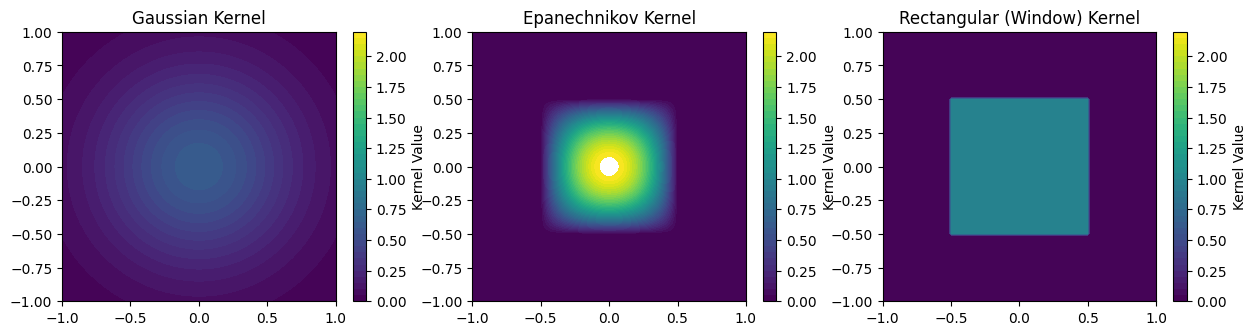

In [7]:
# Generate 2D grid
n = 100
x = np.linspace(-1, 1, n)
X, Y = np.meshgrid(x, x)
eval_pts = np.array([X.flatten(), Y.flatten()]).T

# Evaluate kernels on the grid
h = 0.5
d = 2
Z_gauss     = (1/h**d) * prod_kernel(eval_pts / h, kernel=kernel_gauss).reshape(n, n)
Z_epa       = (1/h**d) * prod_kernel(eval_pts / h, kernel=kernel_epa).reshape(n, n)
Z_window    = (1/h**d) * prod_kernel(eval_pts / h, kernel=kernel_window).reshape(n, n)

# Determine common contour levels for all plots
common_levels = np.arange(np.min([Z_gauss, Z_epa, Z_window]), np.max([Z_gauss, Z_epa, Z_window]), 0.05)

# - - - - - - - - - - - - - - - - - - - - - - - -
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 3.5))

# Gauss Kernel
c1 = axs[0].contourf(X, Y, Z_gauss, levels=common_levels, cmap='viridis')
axs[0].set_title('Gaussian Kernel')

# Epanechnikov Kernel
c2 = axs[1].contourf(X, Y, Z_epa, levels=common_levels, cmap='viridis')
axs[1].set_title('Epanechnikov Kernel')

# Rectangular (Window) Kernel
c3 = axs[2].contourf(X, Y, Z_window, levels=common_levels, cmap='viridis')
axs[2].set_title('Rectangular (Window) Kernel')

# Add colorbars
fig.colorbar(c1, ax=axs[0], orientation='vertical', label='Kernel Value')
fig.colorbar(c2, ax=axs[1], orientation='vertical', label='Kernel Value')
fig.colorbar(c3, ax=axs[2], orientation='vertical', label='Kernel Value')

plt.show()

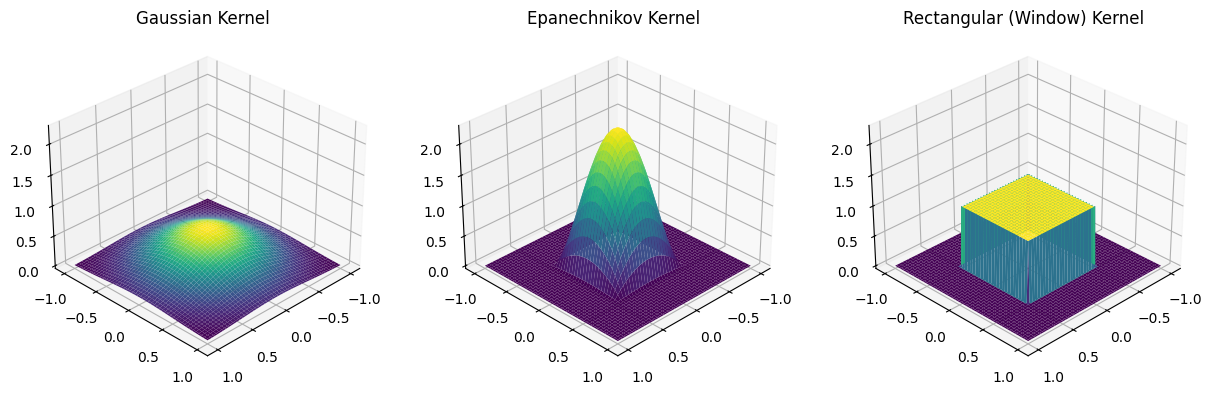

In [8]:
# Plotting in 3D
fig = plt.figure(figsize=(15, 5))

common_vmin = min(Z_gauss.min(), Z_epa.min(), Z_window.min())
common_vmax = max(Z_gauss.max(), Z_epa.max(), Z_window.max())

# Gaussian Kernel
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, Z_gauss, cmap='viridis')
ax1.set_title('Gaussian Kernel')

# Epanechnikov Kernel
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, Z_epa, cmap='viridis')
ax2.set_title('Epanechnikov Kernel')

# Rectangular (Window) Kernel
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X, Y, Z_window, cmap='viridis')
ax3.set_title('Rectangular (Window) Kernel')

for ax in [ax1, ax2, ax3]:
    ax.view_init(elev=30, azim=45)  # Set the view angle
    ax.set_zlim(common_vmin, common_vmax)

plt.show()

#### 2-dim KDE

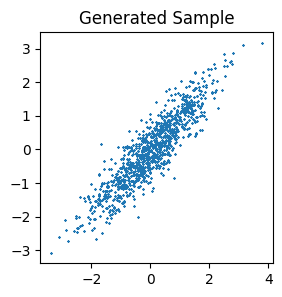

In [36]:
# - - - - - - - - - - - - - - - - - - - - - - - -
# generate normal sample
mean = [0, 0]
rho = 0.9
covariance = [[1, rho], [rho, 1]]

n = 1_000
sample = np.random.multivariate_normal(mean, covariance, size=n)

# - - - - - - - - - - - - - - - - - - - - - - - -
# Plot generated sample point cloud
fig = plt.figure(figsize=(3, 3))
plt.scatter(sample[:, 0], sample[:, 1], s=1, marker='x')
plt.title('Generated Sample')
plt.show()

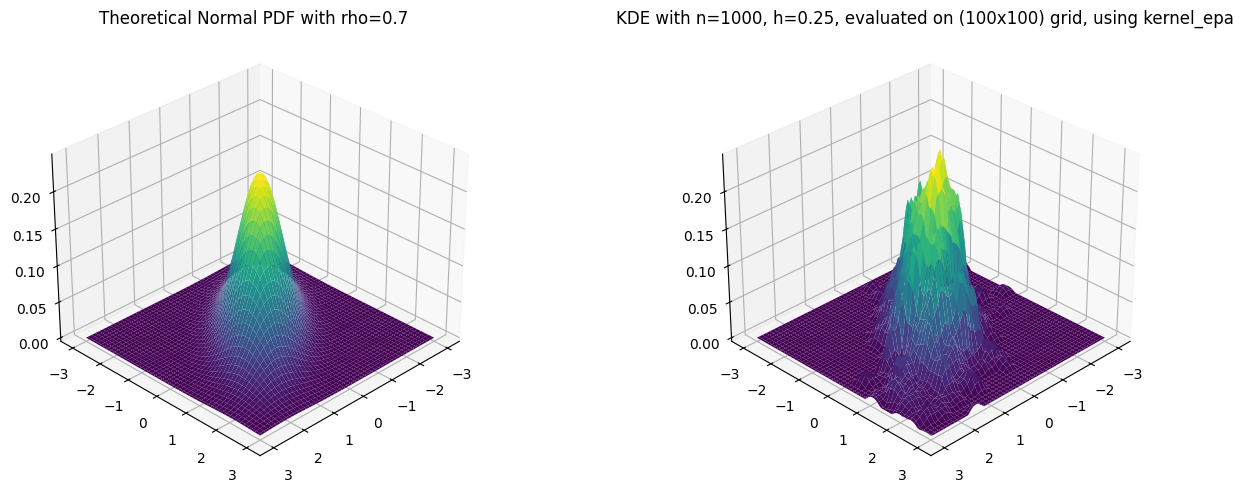

In [28]:
# - - - - - - - - - - - - - - - - - - - - - - - -
# generate normal sample
mean = [0, 0]
rho = 0.7
covariance = [[1, rho], [rho, 1]]

n = 1_000
sample = np.random.multivariate_normal(mean, covariance, size=n)

# - - - - - - - - - - - - - - - - - - - - - - - -
# Evaluate KDE on a grid
n_grid = 100
x = np.linspace(-3, 3, n_grid)
X, Y = np.meshgrid(x, x)
eval_pts = np.array([X.flatten(), Y.flatten()]).T

# Calculate KDE
h = 0.25
kernel_type = kernel_epa
pdf_kde = kde(eval_pts, sample, kernel=kernel_type, h=h).reshape(n_grid, n_grid)

# Theoretical Normal PDF
normal_pdf = multivariate_normal.pdf(eval_pts, mean=mean, cov=covariance).reshape(n_grid, n_grid)

# - - - - - - - - - - - - - - - - - - - - - - - -
# Create figure and 3D axis
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plot theoretical Normal PDF surface
ax1.plot_surface(X, Y, normal_pdf, cmap='viridis')
ax1.set_title(f'Theoretical Normal PDF with rho={rho}')

# Plot KDE PDF surface
ax2.plot_surface(X, Y, pdf_kde, cmap='viridis')
ax2.set_title(f'KDE with n={n}, h={h}, evaluated on ({n_grid}x{n_grid}) grid, using {kernel_type.__name__}')

common_vmin = min(normal_pdf.min(), pdf_kde.min())
common_vmax = max(normal_pdf.max(), pdf_kde.max())

for ax in [ax1, ax2]:
    ax.view_init(elev=30, azim=45)  # Set the view angle
    ax.set_zlim(common_vmin, common_vmax)

plt.tight_layout()
plt.show()

In [24]:
from mayavi import mlab

# Generate normal sample
np.random.seed(123)

mean = [0, 0]
rho = 0.7
covariance = [[1, rho], [rho, 1]]
n = 5_000
sample = np.random.multivariate_normal(mean, covariance, size=n)

# Generate grid to evaluate KDE on
n_grid = 100
x = np.linspace(-2, 2, n_grid)
X, Y = np.meshgrid(x, x)
eval_pts = np.array([X.flatten(), Y.flatten()]).T

h = 0.3
kde_pdf = kde(eval_pts, sample, kernel=kernel_epa, h=h).reshape(n_grid, n_grid)
normal_pdf = multivariate_normal.pdf(eval_pts, mean=mean, cov=covariance).reshape(n_grid, n_grid)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# mayvi 3D plot of surfaces on top of each other

mlab.clf()
fig = mlab.figure(size=(800, 800))
fig.scene.renderer.use_depth_peeling = 1
# fig.scene.camera.zoom(0.5)

ax_max = 3
ax_extent = [-ax_max,ax_max,-ax_max,ax_max,0,ax_max]
surf1 = mlab.mesh(X, Y, kde_pdf, extent=ax_extent, colormap='Reds', opacity=0.8, 
                name='KDE PDF')
surf2 = mlab.mesh(X, Y, normal_pdf, extent=ax_extent, colormap='Blues', opacity=0.6, 
                name='Theoretical Normal PDF')

mlab.view(azimuth=30, elevation=60, distance=20)
mlab.show()

In [23]:
# Loop over different h values and Kernels
h_arr = [0.05, 0.10, 0.25, 0.30]
kernels_arr = [kernel_gauss, kernel_epa, kernel_window]

# Theoretical Normal PDF
normal_pdf = multivariate_normal.pdf(eval_pts, mean=mean, cov=covariance).reshape(n_grid, n_grid)

# Axis scalings for mayavi plot
ax_max = 3
ax_extent = [-ax_max, ax_max, -ax_max, ax_max, 0, ax_max]

for h in h_arr:
    for kernel_type in kernels_arr:

        kde_pdf = kde(eval_pts, sample, kernel=kernel_type, h=h).reshape(n_grid, n_grid)
        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        # mayvi 3D plot of surfaces on top of each other

        mlab.clf()
        fig = mlab.figure(size=(800, 800))
        fig.scene.renderer.use_depth_peeling = 1

        surf1 = mlab.mesh(X, Y, kde_pdf, extent=ax_extent, colormap='Reds', opacity=0.8, 
                        name='KDE PDF')
        surf2 = mlab.mesh(X, Y, normal_pdf, extent=ax_extent, colormap='Blues', opacity=0.6, 
                        name='Theoretical Normal PDF')

        mlab.view(azimuth=30, elevation=60, distance=18)
        mlab.savefig(f"{kernel_type.__name__}, n={n}, h={h}, eval on ({n_grid}x{n_grid}) grid.jpg")
        mlab.close()

mlab.close(all=True)